Following the notebook S8_CNN_ImageClassification_TransferLearning_template.ipynb:  
Follow the steps to successfully apply transfer learning to your classification problem (cats & dogs)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow_datasets as tfds

# Transfer Learning on Cat vs. Dog Image Classification
 


## Explore the Example Data

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2023-01-22 09:58:49--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   105MB/s    in 0.6s    

2023-01-22 09:58:50 (105 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain `cats` and `dogs` subdirectories. Let's define each of these directories:

In [3]:
import os
import zipfile

base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [4]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [5]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

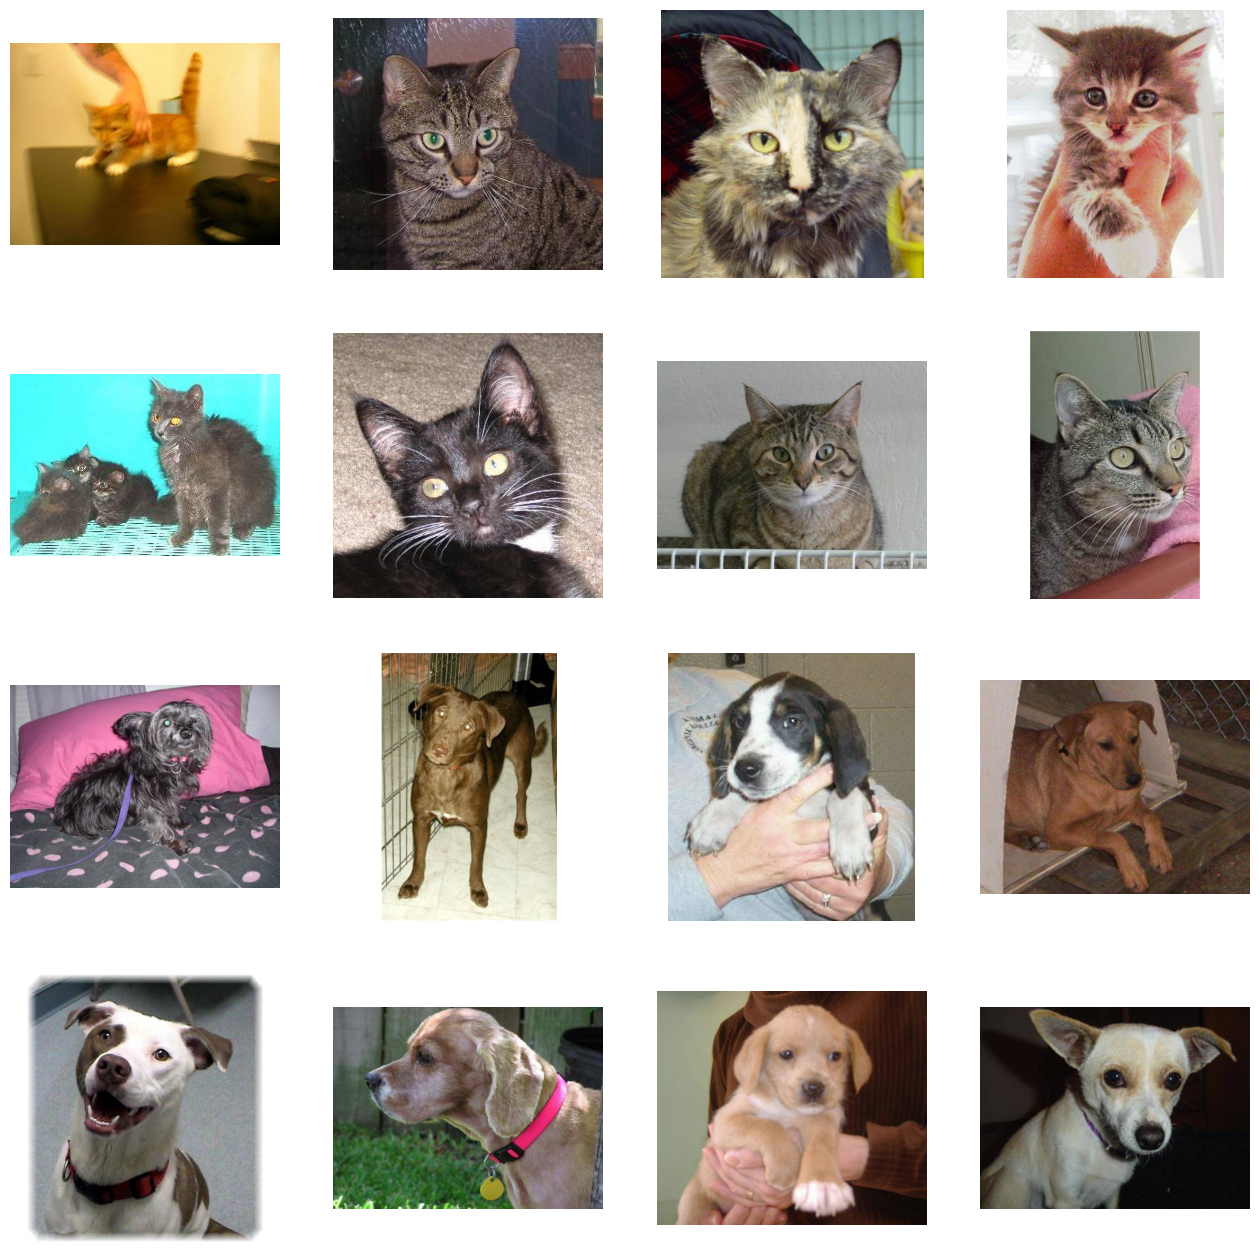

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [26]:
BATCH_SIZE = 32
IMG_SIZE = (150, 150)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


On top of it we stick two fully-connected layers. Because we are facing a two-class classification problem, i.e. a *binary classification problem*, we could  end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function). In that case the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0). But for the sake of generalitation to N classes, we will work with two output units and softmax. 

## Use a large pre-trained model as base model

In [9]:
IMG_SHAPE = (150, 150, 3)
# TODO 1: Download for keras applications inceptionV3 with 'imagenet weights'
# and without the top layer (softmax classification layer)  
# Specify input_shape to IMG_SHAPE (150, 150, 3)
base_model = keras.applications.inception_v3.InceptionV3(
    weights = "imagenet",
    include_top = False,
    input_shape = (150, 150, 3)
) 

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
# Freeze the inceptionV3 (base_model) layers. This will prevent to change its
# weights when training the final classifier 
for layer in base_model.layers:
  layer.trainable = False

In [30]:
# TODO 2: Complete the code to create your cat vs dog classifier using the base model.

# This will work by linking several pieces...
inputs = keras.Input(shape=(150, 150, 3))
inputs_rescaled = layers.Rescaling(1./255)(inputs)
# Connect your inputs as the inputs of the input model
x = base_model(inputs_rescaled, training = False)
# Now x contains the base model connected to the inputs. Note that the base model
# does not include a classification layer, so 
x = layers.Flatten()(x)
# add your classification layer for cats and dogs connecting x as input
outputs = layers.Dense(2, activation='softmax')(x)
# finally, generate your new classification model 
cnn_tl = keras.Model(inputs, outputs)

In [31]:
cnn_tl.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │        36,866 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,839,650 (83.31 MB)

 Trainable params: 36,866 (144.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [32]:
cnn_tl.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

In [33]:
# if you correctly did the steps above, you should see an impressive 0.9X accuracy in both
# training and validation sets
history_with_tl = cnn_tl.fit(train_dataset, epochs=15, validation_data=validation_dataset, verbose=2)

Epoch 1/15
63/63 - 24s - 377ms/step - accuracy: 0.8915 - loss: 0.3354 - val_accuracy: 0.9310 - val_loss: 0.2478
Epoch 2/15
63/63 - 16s - 255ms/step - accuracy: 0.9540 - loss: 0.1297 - val_accuracy: 0.9440 - val_loss: 0.1609
Epoch 3/15
63/63 - 15s - 242ms/step - accuracy: 0.9715 - loss: 0.0798 - val_accuracy: 0.9290 - val_loss: 0.2456
Epoch 4/15
63/63 - 15s - 236ms/step - accuracy: 0.9840 - loss: 0.0494 - val_accuracy: 0.9380 - val_loss: 0.2186
Epoch 5/15
63/63 - 15s - 238ms/step - accuracy: 0.9895 - loss: 0.0315 - val_accuracy: 0.9500 - val_loss: 0.1544
Epoch 6/15
63/63 - 15s - 239ms/step - accuracy: 0.9890 - loss: 0.0284 - val_accuracy: 0.9520 - val_loss: 0.1482
Epoch 7/15
63/63 - 15s - 236ms/step - accuracy: 0.9965 - loss: 0.0120 - val_accuracy: 0.9530 - val_loss: 0.1641
Epoch 8/15
63/63 - 15s - 241ms/step - accuracy: 0.9995 - loss: 0.0046 - val_accuracy: 0.9570 - val_loss: 0.1509
Epoch 9/15
63/63 - 15s - 236ms/step - accuracy: 0.9955 - loss: 0.0109 - val_accuracy: 0.9570 - val_loss:

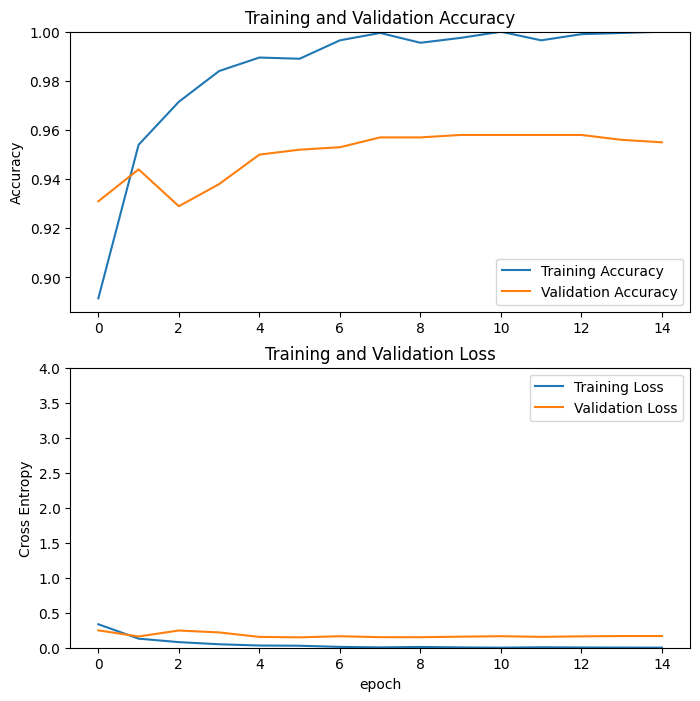

In [36]:
def plot_accuracy_and_loss(history):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,4.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

plot_accuracy_and_loss(history_with_tl)